# ERC20 的代幣分布

嘗試分析 Maxi Doge (MAXI) 這個**毗貅盤**的以下問題

basic
- 查询代币持有者数量和代币的总流通量
- 查询持有代币最多的地址
- 查询不同代币持有者的持有金额分布

advance
- 查询 coin 代币持有者数量随日期的变化情况


## basic

透過 OKX LINK 查到 FFT coin 的 ERC20 smart contract

`https://www.oklink.com/zh-hant/ethereum/token/0x9796b9e60587495d27eb251a832c1d397fc2e028`

地址是: `0x9796b9e60587495d27eb251a832c1d397fc2e028`

稍微在 ETH SCAN 讀一下該智能合約的介面，確實基於 ERC20 Protocol，所以可以透過監視 `transfer` event 來得知幣分布

`https://etherscan.io/address/0x9796b9e60587495d27eb251a832c1d397fc2e028#events`

event id (topic0): `0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef`

- topic1: "address from"
- topic2: "address to"
- data: "value"

透過以下 SQL 抓取相關數據

```SQL
SELECT
  transaction_hash,
  topics[SAFE_OFFSET(1)] as addr_from,
  topics[SAFE_OFFSET(2)] as addr_to,
  data as value,
  block_timestamp
FROM `bigquery-public-data.crypto_ethereum.logs`
WHERE
  address = LOWER('0x9796b9e60587495d27eb251a832c1d397fc2e028')
  AND topics[SAFE_OFFSET(0)] = LOWER('0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef')
  --合約創建到今天--
  AND (DATE(block_timestamp) >= '2025-11-14' AND DATE(block_timestamp) < '2025-12-17')
```


In [97]:
from datetime import time, datetime

import pandas as pd

# 1. 讀取資料
df = pd.read_json("bq-results-20251217-223343-1765982515663.jsonl", lines=True)

# 2. 將 16 進位字串轉換為數值（向量化處理，速度極快）
# 假設 row[3] 是轉帳金額，row[1] 是 from_address，row[2] 是 to_address
values = df.iloc[:, 3].apply(lambda x: int(x, 16))

# 3. 分別計算轉出與轉入的總和
# 轉出地址 (row[1]) 扣錢
out_flow = df.iloc[:, 1].to_frame(name='address')
out_flow['delta'] = -values

# 轉入地址 (row[2]) 加錢
in_flow = df.iloc[:, 2].to_frame(name='address')
in_flow['delta'] = values

# 4. 合併兩張表並加總 (Group By)
df = pd.concat([out_flow, in_flow]).groupby('address')['delta'].sum().reset_index()
print(df.head()) # 觀察初始地址的 0x0 就是貨幣供給量，數字沒錯的話應為 -1000000000000000000，可以透過 ERC20 Read Method 查到

                                             address                delta
0  0x00000000000000000000000000000000000000000000... -1000000000000000000
1  0x00000000000000000000000000000000009726632680...                    0
2  0x00000000000000000000000000000000a991c429ee2e...             16777216
3  0x00000000000000000000000000000047bb99ea4d791b...             13766755
4  0x000000000000000000000000000000fee13a103a10d5...      270241600086646


-1000000000000000000
0x0000000000000000000000003c41ff6ac8fd2d5f5c1997dc2d3809e0e11368f2


<Axes: >

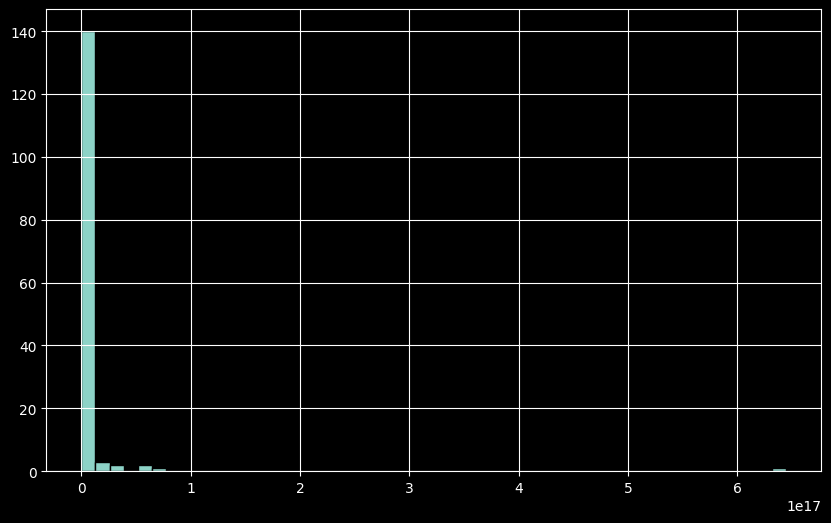

In [98]:
# 總流通量
print(df.sort_values('delta',ascending=True).iloc[0]['delta'])

# address have max coin
print(df.sort_values('delta',ascending=False).iloc[0]['address'])

# money distribute
import matplotlib.pyplot as plt

# 1. 篩選出大於 0 的持倉（過濾掉 0x0 和沒變動的地址）
df = df.sort_values('delta',ascending=True)
positive_balances = df[df['delta'] > 0]['delta']

# 2. 繪製直方圖 (Histogram)
plt.figure(figsize=(10, 6))
positive_balances.hist(bins=50, edgecolor='black')

## 查询 coin 代币持有者数量随日期的变化情况

In [104]:
import pandas as pd

# 1. 讀取與基礎處理
df = pd.read_json("bq-results-20251217-223343-1765982515663.jsonl", lines=True)
df['transfer_num'] = df.iloc[:, 3].apply(lambda x: int(x, 16))
df['day'] = pd.to_datetime(df['block_timestamp']).dt.date

# 2. 建立正負變動表 (向量化操作)
# 直接利用原 df 減少記憶體拷貝
part1 = df[['day', 'transfer_num', 'addr_from']].rename(columns={'addr_from': 'address'})
part1['transfer_num'] = -part1['transfer_num']

part2 = df[['day', 'transfer_num', 'addr_to']].rename(columns={'addr_to': 'address'})

# 3. 按「天」與「地址」先做預歸併 (Pre-aggregation)
# 這步能大幅減少數據行數，加速後續運算
combined_df = pd.concat([part1, part2], ignore_index=True)
daily_summary = combined_df.groupby(['day', 'address'])['transfer_num'].sum().reset_index()

# 4. 計算累積餘額 (核心優化)
# 依照地址分組，並對時間序列執行累加
daily_summary = daily_summary.sort_values(['address', 'day'])
daily_summary['balance'] = daily_summary.groupby('address')['transfer_num'].cumsum()

# 5. 輸出指定日期的結果 (取代 for loop 中的頻繁計算)
# 先定義你要觀察的日期範圍
start_date = pd.to_datetime('2025-11-15').date()
end_date = start_date + pd.Timedelta(days=32)

# 只過濾出範圍內的日期，並顯示每天持倉前 5 名
for current_date in pd.date_range(start_date, end_date).date:
    print(f"\n--- Date: {current_date} ---")
    # 找出該日期（或該日期前最後一次變動）的餘額
    # logic: 篩選小於等於該日的最後一筆紀錄
    day_state = daily_summary[daily_summary['day'] <= current_date]
    top_holders = day_state.groupby('address').last().sort_values('balance', ascending=False)

    # max holder coin
    print(top_holders[['balance']].head())

    ## how many holder
    print(day_state.groupby('address').last()[day_state.groupby('address').last()['balance'] > 0]['balance'].count())


--- Date: 2025-11-15 ---
                                                              balance
address                                                              
0x0000000000000000000000007943e385388018d8821d8...  24277376820264020
0x000000000000000000000000724b669b16824872af3cd...  23755580000000000
0x00000000000000000000000025c91a3238ec98eef26f9...  21546365000000000
0x00000000000000000000000043fdb0db16035bbb21445...  21546365000000000
0x000000000000000000000000a434595c59dfbde96fe89...  20449497266617077
1305

--- Date: 2025-11-16 ---
                                                              balance
address                                                              
0x0000000000000000000000007943e385388018d8821d8...  24277376820264020
0x000000000000000000000000724b669b16824872af3cd...  23755580000000000
0x00000000000000000000000043fdb0db16035bbb21445...  21546365000000000
0x00000000000000000000000025c91a3238ec98eef26f9...  21546365000000000
0x000000000000000000000000a434595